<a href="https://colab.research.google.com/github/mnbpdx/langgraph-agents/blob/main/initial_api_call_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# inital api call agent

this agent has a retrieval node that calls an api. Unfinished, retrieval node needs to actually make a call. but fully working otherwise


## install dependencies

In [1]:
%pip install --quiet -U langchain_openai langchain_core langgraph langchain-pinecone pinecone-notebooks

## set the OpenAI API Key

In [2]:
import os, getpass

def _set_env(var: str):
  if not os.environ.get(var):
    os.environ[var] = getpass.getpass(f"Enter your {var}: ")

_set_env("OPENAI_API_KEY")

Enter your OPENAI_API_KEY: ··········


## define the LLM model

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

## define tools

In [12]:
def cozy_day():
  """
  If it looks like it's going to be a cozy inside weather day,
  run this funtion.

  """
  print("cozy day!")

def outside_day():
  """
  If it looks like it's going to be a fun outside weather day,
  run this funtion.
  """
  print("outside day!")

tools = [cozy_day, outside_day]

## bind tools to the LLM

In [13]:
llm_with_button_press_tool = llm.bind_tools(tools)

## build the LLM node

In [14]:
from langgraph.graph import MessagesState
from langchain_core.messages import trim_messages

def llm_with_button_press_tool_node(state: MessagesState):

  # trim the messages to the last 150 tokens worth
  messages = trim_messages(
      messages=state["messages"],
      strategy="last",
      token_counter=ChatOpenAI(model="gpt-4o-mini"),
      max_tokens=150,
      start_on="human",
      allow_partial=False,
  )

  return {"messages": [llm_with_button_press_tool.invoke(messages)]}

## build the retrieval node

In [31]:
from langchain_core.messages import SystemMessage

def tara_demo_function() -> str:
    return "It's gonna be a sunny day out there."

def retrieval_node(state: MessagesState):
    weather_related_text_to_pass_llm = tara_demo_function()

    # Create a new SystemMessage
    system_message = SystemMessage(content=weather_related_text_to_pass_llm)

    result_message = {"messages": [system_message] + state["messages"]}

    # Return the updated messages state including the new SystemMessage
    return result_message

## build the graph

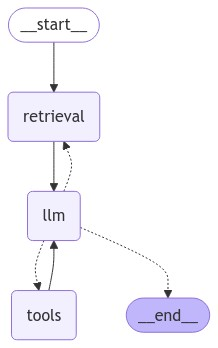

In [32]:
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image

builder = StateGraph(MessagesState)

# add nodes
builder.add_node("retrieval", retrieval_node)
builder.add_node("llm", llm_with_button_press_tool_node)
builder.add_node("tools", ToolNode(tools))

# connect them (add edges)
builder.add_edge(START, "retrieval")
builder.add_edge("retrieval", "llm")
builder.add_conditional_edges("llm", tools_condition)
builder.add_edge("tools", "llm")

# memory = MemorySaver()
# graph = builder.compile(checkpointer=memory)
graph = builder.compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## invoke the graph


In [33]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}

messages = [HumanMessage(content="what kind of day is it gonna be?")]
messages = graph.invoke(input={"messages": messages}, config=config)

for m in messages['messages']:
    m.pretty_print()

outside day!
================================ Human Message =================================

what kind of day is it gonna be?
================================ System Message ================================

It's gonna be a sunny day out there.
================================== Ai Message ==================================
Tool Calls:
  outside_day (call_nraFNaeDvulsFILhxufgbkog)
 Call ID: call_nraFNaeDvulsFILhxufgbkog
  Args:
================================= Tool Message =================================
Name: outside_day

null
================================== Ai Message ==================================

It sounds like it's going to be a fun outside day! Enjoy the sunshine!
